<a href="https://colab.research.google.com/github/ggsmith842/Aggie_YelperHelper/blob/master/Fine_Tuning_AlexNet_with_PyTorch_%26_Hugging_Face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AlexNet

LeNet was succeeded by AlexNet which contains 8 layers instead of 5 and an increase of 60m parameters compared to LeNet's 60k.  

Additionally, AlexNet was trained on significantly more data and uses max pooling instead of average pooling.

In [1]:
# !pip install huggingface_hub

Overview of AlexNet implemented using `PyTorch`

```
class AlexNet(nn.Module):
  def __init__(self, n_classes):
    super(AlexNet. self).__init__()
    self.features = nn.Sequential(
        nn.Conv2d(in_channels = 3,      # 1st layer
                  out_channels = 64,
                  kernel_size = 11,
                  stride = 4,
                  padding = 5
                  )
        ),
    nn.ReLU(),                          # activation function
    nn.MaxPool2d(2,2),                  # pooling

    nn.Conv2d(64, 192, 5, 2),           # 2nd layer
    nn.ReLU(),
    nn.MaxPool2d(2,2)

    nn.Conv2d(192, 384, 3, 1),          # 3rd layer
    nn.ReLU(),
    nn.MaxPool2d(2,2),

    nn.Conv2d(384, 256, 3, 1),          # 4th layer
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    
    nn.Conv2d(256, 256, 3, 1),          # 5th layer
    nn.ReLU(),
    nn.MaxPool2d(2, 2)
    
    
    self.clf = nn.Linear(in_features=256, out_features=n_classes)

  def forward(self, input):
    op = self.features(input)
    op = op.view(op.size(0), -1)
    op = self.clf(op)
    return op

```



In [2]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim

from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

In [3]:
# set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Download Dataset from Hugging Face

In [4]:
from huggingface_hub import snapshot_download
from huggingface_hub.utils import disable_progress_bars, enable_progress_bars

In [5]:
disable_progress_bars()

# Download from a dataset
local_dir="/content/hymenoptera"
repo_id="ggsmith/Hymenoptera"

# Download only train and val folders
snapshot_download(
    repo_id=repo_id,
    repo_type="dataset",
    local_dir=local_dir,
    allow_patterns=["train/*", "val/*"]
    )

'/content/hymenoptera'

# Fine-Tune AlexNet

## Process Dataset

In [6]:
# calculate mean and std
# Define transformations (only ToTensor for this calculation)
data_transforms = transforms.Compose([
    transforms.ToTensor(),
])

# Load the dataset
dataset = datasets.ImageFolder(root='/content/hymenoptera/train', transform=data_transforms)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=2)

# initialize variables for calculations
mean = torch.zeros(3)
std = torch.zeros(3)
num_pixels = 0


for img, _ in dataloader:
  batch_pixels = img.size(2) * img.size(3) # HxW
  mean += img.sum(dim=[0,2,3]).squeeze()
  std += (img ** 2).sum(dim=[0,2,3]).squeeze()
  num_pixels += batch_pixels

mean /= num_pixels
std = torch.sqrt(std / num_pixels - mean ** 2)

print(f"Mean: {mean}")
print(f"Std: {std}")


Mean: tensor([0.5172, 0.4753, 0.3484])
Std: tensor([0.2776, 0.2575, 0.2865])


In [7]:
# load pre-trained AlexNet from PyTorch
# fine-tune on additional data to demonstrate transfer-learning
dirs = ['train', 'val']

data_transformers = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean.tolist(), std.tolist())]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean.tolist(), std.tolist())
    ])
}

img_data = {k: datasets.ImageFolder(f"{local_dir}/{k}", data_transformers[k]) for k in dirs}
data_loaders = {k: torch.utils.data.DataLoader(img_data[k], batch_size=8, shuffle=True, num_workers=2) for k in dirs}
data_sizes = {x: len(img_data[x]) for x in dirs}
classes = img_data['train'].classes

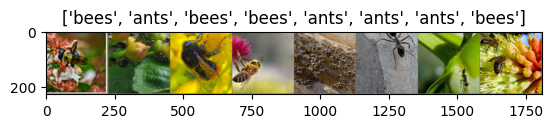

In [8]:
def show_img(img, mean, std, text=None):
  img = img.numpy().transpose((1,2,0))
  img = np.array(std) * img + np.array(mean)
  img = np.clip(img, 0, 1)
  plt.imshow(img)
  if text is not None:
    plt.title(text)

# generate one train dataset batch
imgs, cls = next(iter(data_loaders['train']))

# generate a grid from batch
grid = torchvision.utils.make_grid(imgs)
show_img(grid, mean, std, text=[classes[c] for c in cls])

In [9]:
# fine-tuning loop
def fine_tune(pretrained_model: nn.Module, loss_func: nn.Module, optim: optim.Optimizer, epochs: int =10):
  start = time.time()

  weights = copy.deepcopy(pretrained_model.state_dict())
  accuracy = 0.0

  for epoch in range(epochs):
    print(f'Epoch {epoch}/{epochs - 1}')
    print('='*20)

    # for each epoch run through train/val set
    for dataset in ['train', 'val']:
      if dataset == 'train':
        pretrained_model.train()
      else:
        pretrained_model.eval()

      loss = 0.0
      successes = 0

      # iterate over images and labels
      for imgs, labels in data_loaders[dataset]:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optim.zero_grad()

        with torch.set_grad_enabled(dataset=='train'):
          outputs = pretrained_model(imgs)
          _, preds = torch.max(outputs, 1)
          loss_curr = loss_func(outputs, labels)
          if dataset == 'train':
            loss_curr.backward()
            optim.step()

          loss += loss_curr.item() * img.size(0)
          successes += torch.sum(preds == labels.data)

      loss_epoch = loss / data_sizes[dataset]
      accuracy_epoch = successes.double() / data_sizes[dataset]

      print(f'{dataset} loss in this epoch: {loss_epoch}, accuracy in this epoch: {accuracy_epoch}')
      if dataset == 'val' and accuracy_epoch > accuracy:
        accuracy = accuracy_epoch
        weights = copy.deepcopy(pretrained_model.state_dict())

    print()

  time_delta = time.time() - start

  print(f'Elapsed Training time: {int(time_delta // 60)}m {time_delta % 60:.2f}s')
  print(f'Best validation set accuracy: {accuracy:.2f}')

  # load the best model version (weights)
  pretrained_model.load_state_dict(weights)
  return pretrained_model


In [10]:
def visualize_predictions(model: nn.Module, num_imgs: int = 4):
  torch.manual_seed(1)
  was_model_training = model.training
  model.eval()
  imgs_counter = 0
  fig = plt.figure()

  with torch.no_grad():
    for i, (imgs, labels) in enumerate(data_loaders['val']):
      imgs = imgs.to(device)
      labels = labels.to(device)
      outputs = model(imgs)
      _, preds = torch.max(outputs, 1)

      for j in range(imgs.size()[0]):
        imgs_counter += 1
        ax = plt.subplot(num_imgs//2, 2, imgs_counter)
        ax.axis('off')
        ax.set_title(f'pred: {classes[preds[j]]} || target: {classes[labels[j]]}')
        show_img(imgs.cpu().data[j], mean, std)

        if imgs_counter == num_imgs:
          model.train(mode=was_model_training)
          return
      model.train(mode=was_model_training)



In [11]:
def get_accuracy(model: nn.Module, n_preds: int = 10):
  correct_predictions = 0
  total_predictions = 0
  torch.manual_seed(1)
  was_model_training = model.training
  model.eval()
  imgs_counter = 0

  with torch.no_grad():
    for imgs, labels in data_loaders['val']:
      imgs = imgs.to(device)
      labels = labels.to(device)
      outputs = model(imgs)
      _, preds = torch.max(outputs, 1)


      for j in range(imgs.size()[0]):
        imgs_counter += 1
        if preds[j] == labels[j]:
          correct_predictions +=1
        total_predictions +=1

        if imgs_counter == n_preds:
          break

      if imgs_counter == n_preds:
          break

    accuracy = correct_predictions / total_predictions
    print(f"Accuracy: {accuracy:.2f}%")
    return accuracy



In [12]:
base_model = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
print(base_model.features)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 191MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [13]:
print(base_model.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [14]:
# update output layer to include the coorect
# number of classes  in the new dataset
base_model.classifier[6] = nn.Linear(4096, len(classes))

# set loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optim_finetune = optim.SGD(base_model.parameters(), lr=0.0001)

base_model = base_model.to(device)

In [15]:
base_accuracy = get_accuracy(base_model, len(data_loaders['val'].dataset))
print(f'Base model accuracy: {base_accuracy}')

Accuracy: 0.39%
Base model accuracy: 0.39215686274509803


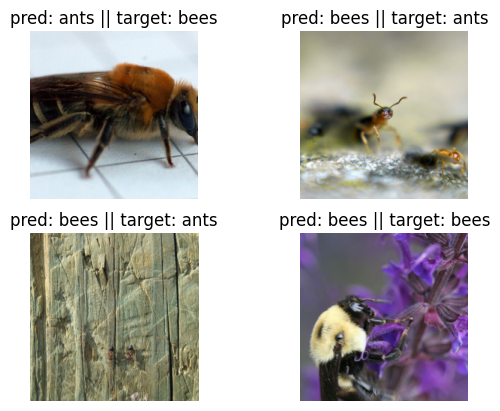

In [16]:
visualize_predictions(base_model, 4)

In [17]:
loss_func = nn.CrossEntropyLoss()
optim_finetune = optim.SGD(base_model.parameters(), lr=0.0001)

# train and validate fine tuning on the model
model_finetune = fine_tune(base_model, loss_func, optim_finetune, epochs=10)

Epoch 0/9
train loss in this epoch: 0.09727211223273981, accuracy in this epoch: 0.5245901639344263
val loss in this epoch: 0.08220224209081113, accuracy in this epoch: 0.607843137254902

Epoch 1/9
train loss in this epoch: 0.07404094397044572, accuracy in this epoch: 0.6803278688524591
val loss in this epoch: 0.06863978261651557, accuracy in this epoch: 0.7254901960784313

Epoch 2/9
train loss in this epoch: 0.06183652836279791, accuracy in this epoch: 0.778688524590164
val loss in this epoch: 0.06305517655572081, accuracy in this epoch: 0.7647058823529412

Epoch 3/9
train loss in this epoch: 0.05370954778350768, accuracy in this epoch: 0.8073770491803279
val loss in this epoch: 0.05783163936309565, accuracy in this epoch: 0.8169934640522876

Epoch 4/9
train loss in this epoch: 0.051872870716892304, accuracy in this epoch: 0.8155737704918034
val loss in this epoch: 0.04996259627388973, accuracy in this epoch: 0.8366013071895425

Epoch 5/9
train loss in this epoch: 0.04056074378676102,

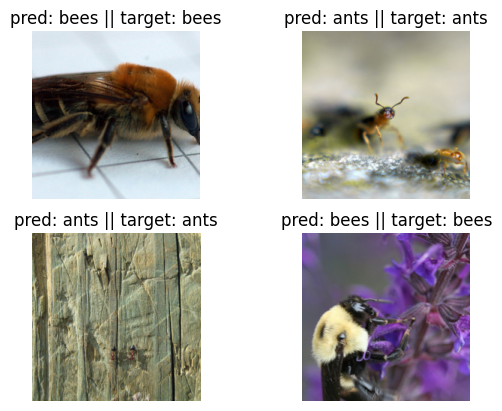

In [18]:
visualize_predictions(model_finetune)

In [36]:
!mkdir model

In [37]:
# save finetuned model
model_path = '/content/model/alexnet-hymenoptera.pt'
torch.save(model_finetune.state_dict(), model_path)

# Upload to Hugging Face

This section covers how we can upload a model to Hugging Face directly from the notebook.

In [20]:
from huggingface_hub import HfApi
from google.colab import userdata
HF_TOKEN = userdata.get('HF_TOKEN')

In [32]:
api = HfApi(token=HF_TOKEN)

In [39]:
api.upload_folder(
    folder_path='/content/model',
    repo_id="ggsmith/alexnet-hymenoptera",
    repo_type="model",
)

CommitInfo(commit_url='https://huggingface.co/ggsmith/alexnet-hymenoptera/commit/5167af9c214c2668333f7ed21ac6e2235013c005', commit_message='Upload folder using huggingface_hub', commit_description='', oid='5167af9c214c2668333f7ed21ac6e2235013c005', pr_url=None, repo_url=RepoUrl('https://huggingface.co/ggsmith/alexnet-hymenoptera', endpoint='https://huggingface.co', repo_type='model', repo_id='ggsmith/alexnet-hymenoptera'), pr_revision=None, pr_num=None)